# Identifying cell populations in single-cell data using Autoencoders

In the first exercise we will use Autoencoders to analyze a population of healthy bone marrow cells and perform dimensionality reduction to identify possible cell subtypes. We will learn to how to construct, configure, and fit Autoencoder networks, and experiment with adding complexity to the network so as to capture more information from the data. 

We will also focus on visualizing and assessing the results after each experimentation, and explain how to pick the best possible network architecture.

# Dataset description

We will use a public benchmark dataset from Levine et al., Cell 162, 184–197 (2015). The data consist of approximately 80,000 single cells, where the abundance of 13 cell surface markers was measured by mass cytometry. In this dataset the existing cell subpopulations are well-characterized by manual gating: through an iterative process of biaxial plotting, the single cells were assigned to different populations, available to us as prior knowledge (labels). Full paper and dataset description is available <a href="http://www.cell.com/cell/fulltext/S0092-8674(15)00637-6">here</a>. 

=> for each sample (single cell), relative abundance of a number of certain proteins

=> every dot = 1 cell

# Load and preprocess raw data

We will use the <a href="https://pandas.pydata.org/pandas"> pandas</a> data analysis library and some data preprocessing functions from <a href="http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing">scikit-learn</a>, the most well-established machine learning library in Python.

In [1]:
def reproduce(seed_number):
    import numpy as np
    import tensorflow as tf
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

In [5]:
#let's start by importing the raw mass cytometry data
import pandas as pd
import os

#go to the location of the raw data file
datapath = '/sib_autumn_school/jupyter_root/data/'
os.chdir(datapath)
#read csv data as a pandas dataframe
data=pd.read_csv('test_data.csv', header=0)
cell_types=pd.read_csv('cell_types.csv', header=0)

#show dimensions of the dataframe
print(data.shape)

# for each single cell (>80000), we have abundance of 14 protein markers

(81075, 14)


In [3]:
#preview the first 5 rows of the dataframe
data.head()

CD45   CD45RA     CD19     CD11b      CD4       CD8      CD34      CD20  \
0  3.1380  1.61860  0.52561 -0.104680  0.81136  1.740700  0.531370 -0.153810   
1  3.4869  2.24780  0.30958  0.833400  1.55060  1.829000 -0.033018  0.290680   
2  2.1455  0.79681 -0.11607  0.186250  0.52990  0.834880  0.734450  1.590900   
3  4.3219  0.16702 -0.63914 -0.020982  1.81420 -0.094315  1.416300 -0.028213   
4  2.6340  0.71486 -0.17389 -0.042410  0.45091  1.587900  0.731610  0.139230   

     CD33    CD123    CD38     CD90       CD3  category  
0  4.2911  2.61520  4.6466  1.84940  1.280000         1  
1  4.6720  1.53290  4.2534  0.42237  0.066806         1  
2  4.4731  0.44348  4.5114  0.12462 -2.066900         1  
3  4.2956  2.54640  5.0041  1.32600 -1.016000         1  
4  4.1153  1.57990  5.0655  0.63290 -0.703900         1

In [6]:
#preview the first 5 rows of the dataframe
cell_types.head()
# we will use the labels for validation

label     cell type name
0      1    CD11b- Monocyte
1      2   CD11bhi Monocyte
2      3  CD11bmid Monocyte
3      4       Erythroblast
4      5                HSC

In [7]:
#get category of each single cell (last column)
labels=data['category']
#get names of protein markers
markers=data.columns[:13]
markers

Index(['CD45', 'CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34', 'CD20', 'CD33',
       'CD123', 'CD38', 'CD90', 'CD3'],
      dtype='object')

Next, we will visualize the data using two python libraries: <a href="https://matplotlib.org">matplotlib</a> and <a href="https://seaborn.pydata.org/">seaborn</a>.

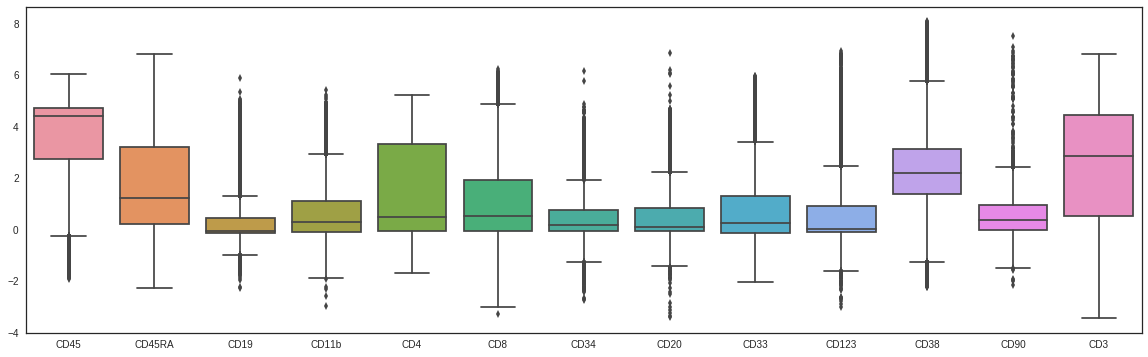

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#plot a boxplot of all markers
f, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=data[markers])
plt.show()

# the markers have different distribution
# expressed in different dynamic regions -> something that we don't want
# => need pre-processing !

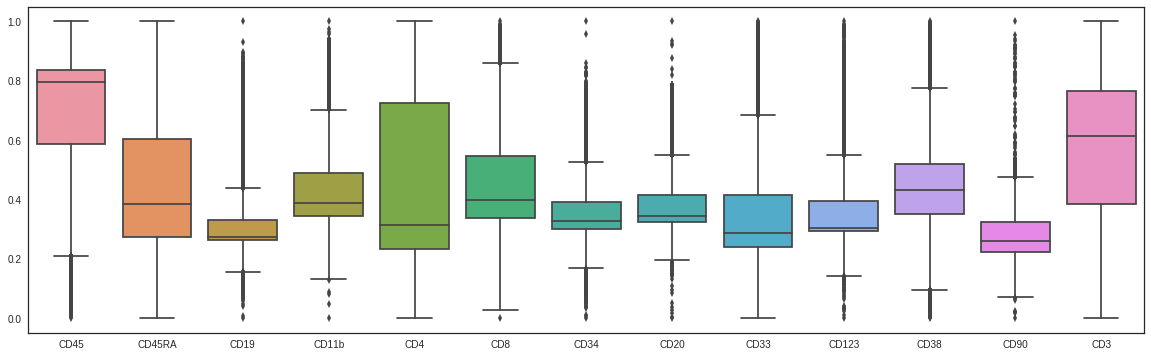

In [12]:
from sklearn.preprocessing import MinMaxScaler

#scale the data from 0 to 1
min_max_scaler = MinMaxScaler( feature_range=(0, 1), copy=True)
data_norm = min_max_scaler.fit_transform(data.as_matrix(columns=data.columns[:13]))

#verify scaling
f, ax = plt.subplots(figsize=(20, 6))
sns.boxplot(data=data_norm)
plt.xticks(range(13),markers)
plt.show()

We are interested to see if and what type of cell subpopulations exist in the data. Let's do a Principal Component Analysis first:

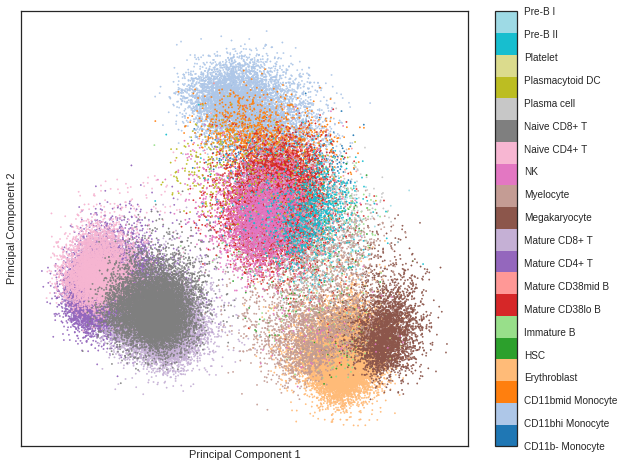

In [13]:
from sklearn.decomposition import PCA

#perform PCA transformation
pca = PCA(n_components=2)
Y = pca.fit_transform(data_norm)

#plot results
fig = plt.figure(figsize=(10, 8))
ax = plt.scatter(Y[:, 0], Y[:, 1], s=2, c=labels, cmap="tab20")
cbar = plt.colorbar(ax, ticks=range(21))
cbar.ax.set_yticklabels(cell_types['cell type name'])
ax.set_facecolor('white')
plt.xticks([])
plt.yticks([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# each dot is 1 cell, color = type of the cell
# with PCA, 4 blocks of cell types

# Create, compile and fit autoencoder model 
We will use <a href="https://keras.io/">Keras</a>, a high-level neural networks API that runs on top of librares like TensorFlow or Theano.

In [16]:
# standard ratio 70% train set

#split the data in training and testing sets
from sklearn.model_selection import train_test_split

# x_ => the data, y_ => the labels [labels only needed for plotting]
x_train, x_test, y_train, y_test = train_test_split(data_norm, labels, test_size=0.3, random_state=10)
print('The training data have',x_train.shape[0], 'rows and', x_train.shape[1], 'columns')
print('The test data have',x_test.shape[0], 'rows and', x_test.shape[1], 'columns')

The training data have 56752 rows and 13 columns
The test data have 24323 rows and 13 columns


Function definitions for plotting results

In [17]:
#plot original data, reconstructed data and residuals.
def plot_reconstruction(data_norm, data_dec):
    plt.figure(figsize=(30,20))
    plt.subplot(3, 1, 1)
    ax1 = plt.imshow(data_norm, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax1)
    plt.title('Original data', fontsize=25)
    plt.subplot(3, 1, 2)
    ax2 = plt.imshow(data_dec, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax2)
    plt.title('Reconstruction', fontsize=25)
    plt.subplot(3, 1, 3)
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
    plt.gca().set_xticks(range(13))
    plt.gca().set_xticklabels(markers, fontsize=20)
    cbar = plt.colorbar(ax3)
    plt.title('Residuals', fontsize=25)
    plt.show()

#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss function')
    plt.legend(['Loss','Validation loss'])
    plt.show()

#plot reduced dimensions    
def plot_encoded(x_train_encoded, y_train):
    fig = plt.figure(figsize=(10, 8))
    ax = plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], s=2, c=y_train, cmap="tab20")
    cbar = plt.colorbar(ax, ticks=range(21))
    cbar.ax.set_yticklabels(cell_types['cell type name'])
    ax.set_facecolor('white')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

Let's start with a simple autoencoder with only 1 hidden layer of 2 nodes:

In [18]:
reproduce(10)

#make necessary imports
from keras.layers import Input, Dense
from keras.models import Model

#set dimensions of input and hidden layer
input_dim = 13
latent_dim = 2

input_data = Input(shape=(input_dim,))
#encode the input with a dense layer 
# dense = fully connected
# -> first part encoding part, using a relu
encoded = Dense(latent_dim, activation='relu')(input_data)
# -> 2nd part: take encoded and decoded
# just give an output
# sigmoid => ensure that the output will scale between 0 to 1
# (we don't want sigmoid in 1st part: saturation of the gradient)
# we have scaled data from 0 to 1 -> so we want that output ranges from 0 to 1
# in the 2nd part, relu will not give meaningful data with respect to the input data
# -> squeeze output to same data range you have in the input
#decode the encoded input to its reconstruction
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# We have set the following neural network:
# 13 parameters in the input, 2 latent dimensions
# encode part: weight matrix=13*2 + 2 biases
# decode part: 2*13 + 13 biases

#autoencoder_1 maps the input to the output
autoencoder_1 = Model(input_data, decoded)

#encoder_1 maps the input to the latent representation
encoder_1 = Model(input_data, encoded)

#decoder_1 maps the encoded input to its reconstruction
encoded_input = Input(shape=(latent_dim,))
decoder_layer = autoencoder_1.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# set here the optimization and cost function you want
#compile the model and set the desired optimizer and loss function
autoencoder_1.compile(optimizer='adam', loss='mean_squared_error')


# we will use the encoder: take input data and pass them to the encoder to see how 
# they look in lower dimension representation

Using TensorFlow backend.


How many parameters does the model have?

In [19]:
#visualize a summary of the network
autoencoder_1.summary()

# how many connections as weights
# how many biases as nodes
# weights are much more numerous than the biases
# 13*2 + 2 + 2*13 + 13 = 67

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 28        
_________________________________________________________________
dense_2 (Dense)              (None, 13)                39        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________


In [23]:
# take input data and set some parameters for the training
#fit the model with training and test data as specified above
autoencoder_1.fit(x_train, x_train,
                epochs=150,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

# for each epoch, you have loss and validation loss
# batch size => depends on the number the data but practically try to exploit
# all CPU (minimze transfer of data from CPU to GPU)

Train on 56752 samples, validate on 24323 samples
Epoch 1/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 2/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 3/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 4/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 5/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 6/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 7/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 8/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 9/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch

Epoch 78/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 79/150
56752/56752 [==============================] - 0s 5us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 80/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 81/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 82/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 83/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 84/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 85/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 86/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0120 - val_loss: 0.0120
Epoch 87/150
56752/56752 [====================

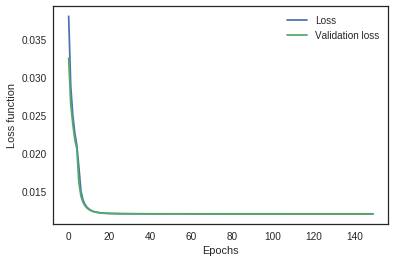

In [21]:
# loss fucntion across the epoch to see how goes the learning

#visualize the history of traing and testing the model
plot_history(autoencoder_1)

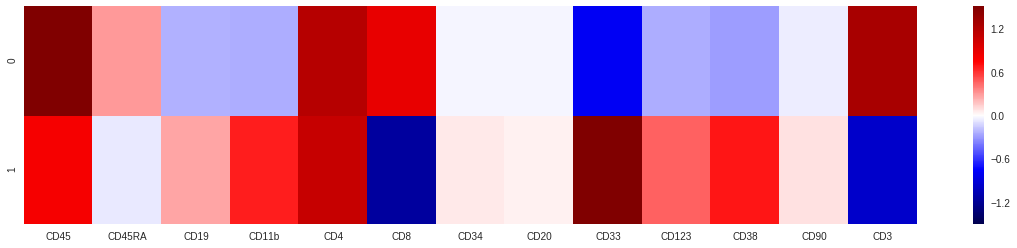

In [24]:
#get the weights of the hidden layer
weights=autoencoder_1.layers[2].get_weights()
#visualize the weights
plt.figure(figsize=(20,4))
sns.heatmap(data=weights[0], cmap='seismic')
plt.gca().set_xticklabels(markers)
plt.show()

# layer visualization:
# visualize the weights: 2x13 

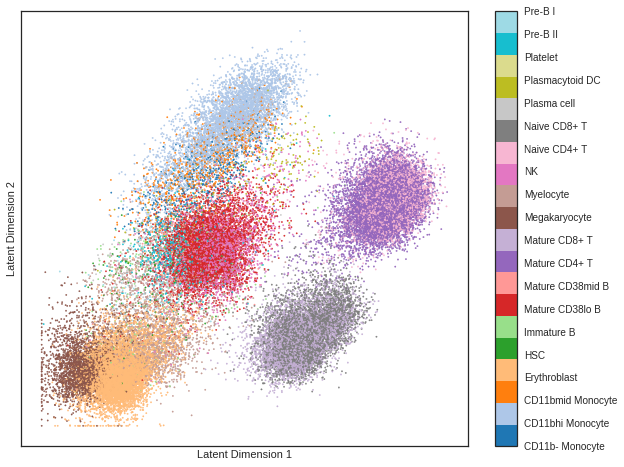

In [25]:
#encode input into latent dimensions
x_enc_1 = encoder_1.predict(x_train, batch_size=256)
plot_encoded(x_enc_1, y_train)

# stochasticity: don't get the same result each time
# better than the PCA, but still some mixture

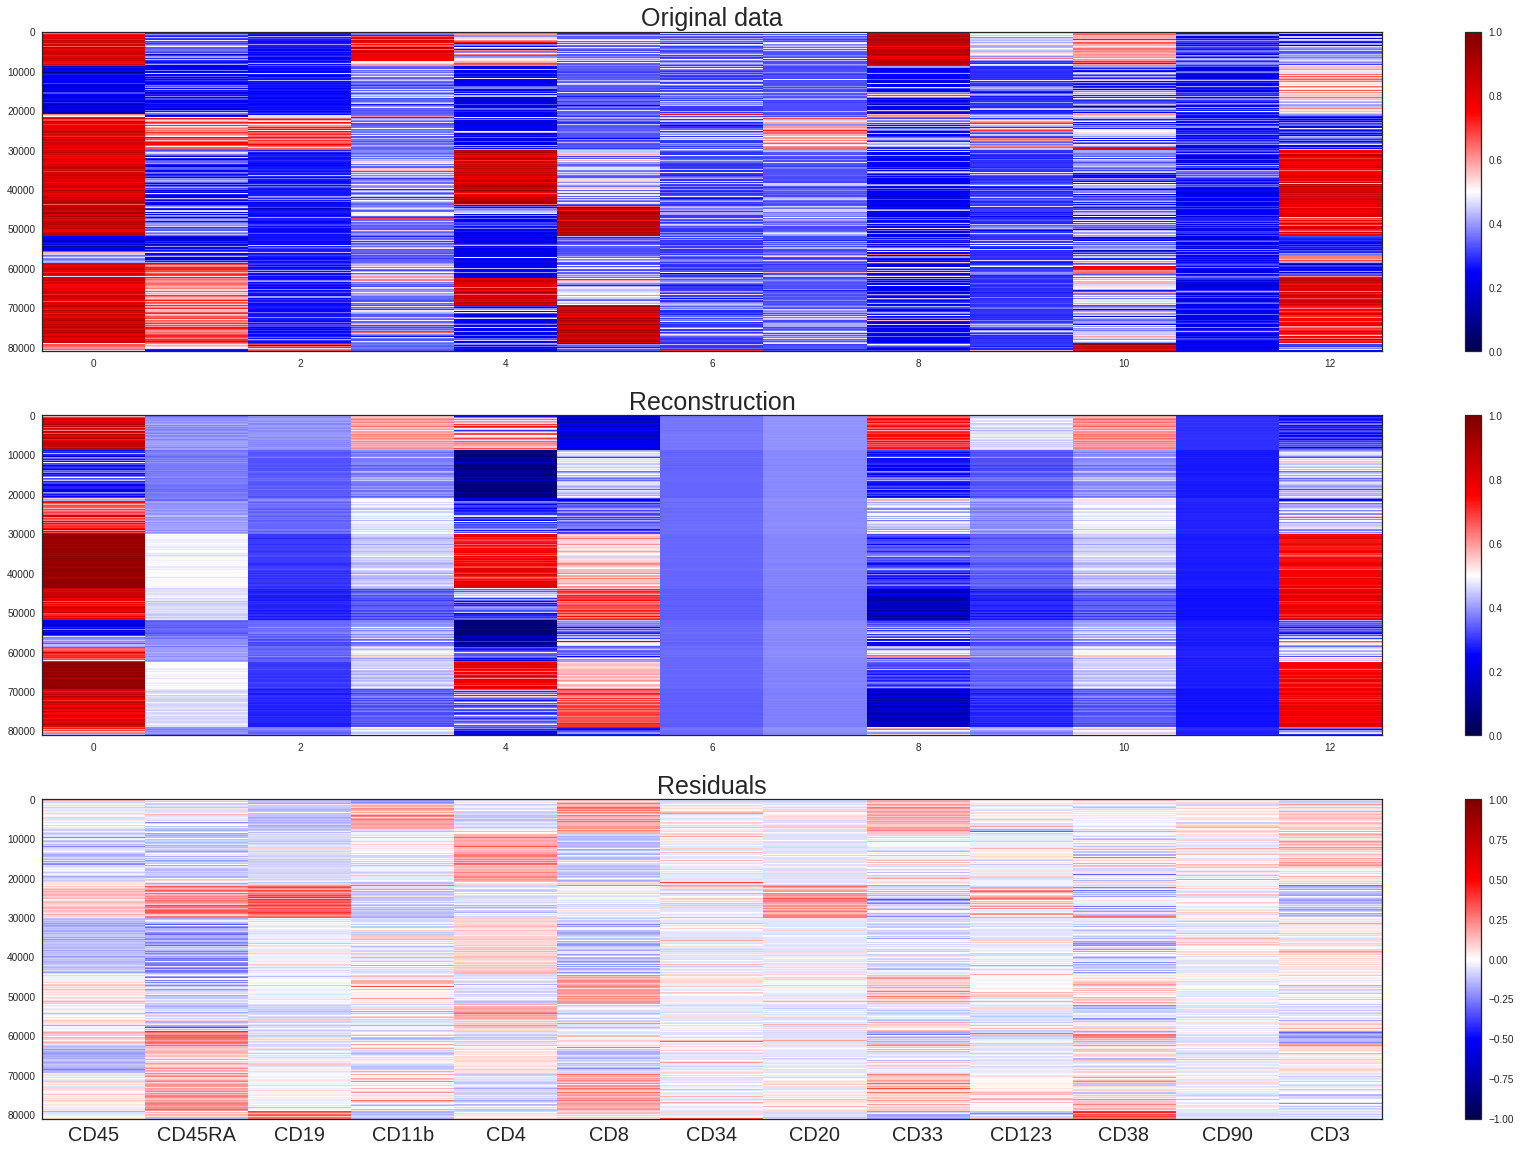

In [26]:
#reconstruct the data
data_dec_1 = autoencoder_1.predict(data_norm)
plot_reconstruction(data_norm, data_dec_1)

# original data: columns = markers, rows = single cells, blocks because organized by cell type
# reconstruction: getting some information (good for some cells/markers) but loosing some information
# residuals: a way to assess what you did

Now let's create a more complex network with 2 hidden layers:

In [27]:
# add one hidden layer 13 -> 7 -> 2 -> 7 -> 13
# break the initial by 2 in an additional layer

reproduce(100)
input_dim = 13
intermediate_dim = 7
latent_dim = 2

input_data = Input(shape=(input_dim,))
encoded_1 = Dense(intermediate_dim, activation='relu')(input_data)
encoded_2 = Dense(latent_dim, activation='relu')(encoded_1)
decoded_1 = Dense(intermediate_dim, activation='relu')(encoded_2)
decoded_2 = Dense(input_dim, activation='sigmoid')(decoded_1)

autoencoder_2 = Model(input_data, decoded_2)

encoder_2 = Model(input_data, encoded_2)
encoded_input_2 = Input(shape=(latent_dim,))
decoder_layer_2 = autoencoder_2.layers[-1]
decoder_2 = Model(encoded_input, decoder_layer(encoded_input))

autoencoder_2.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_2.summary()
autoencoder_2.fit(x_train, x_train,
                epochs=150,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 98        
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 16        
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 21        
_________________________________________________________________
dense_6 (Dense)              (None, 13)                104       
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________
Train on 56752 samples, validate on 24323 samples
Epoch 1/150
56752/56752 [==============================] - 0s 8us/step - loss: 0.0314 - val_lo

56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 69/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 70/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 71/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 72/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 73/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 74/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 75/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 76/150
56752/56752 [==============================] - 0s 6us/step - loss: 0.0065 - val_loss: 0.0065
Epoch 77/150
56752/56752 [==============================] -

Epoch 145/150
56752/56752 [==============================] - 1s 9us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 146/150
56752/56752 [==============================] - 1s 10us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 147/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0064 - val_loss: 0.0064
Epoch 148/150
56752/56752 [==============================] - 0s 8us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 149/150
56752/56752 [==============================] - 0s 8us/step - loss: 0.0063 - val_loss: 0.0064
Epoch 150/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0063 - val_loss: 0.0063


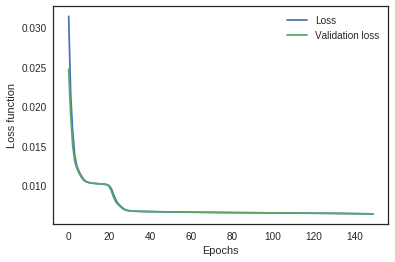

In [29]:
plot_history(autoencoder_2)

# elbow: local minima, get stuck somewhere, then can escape


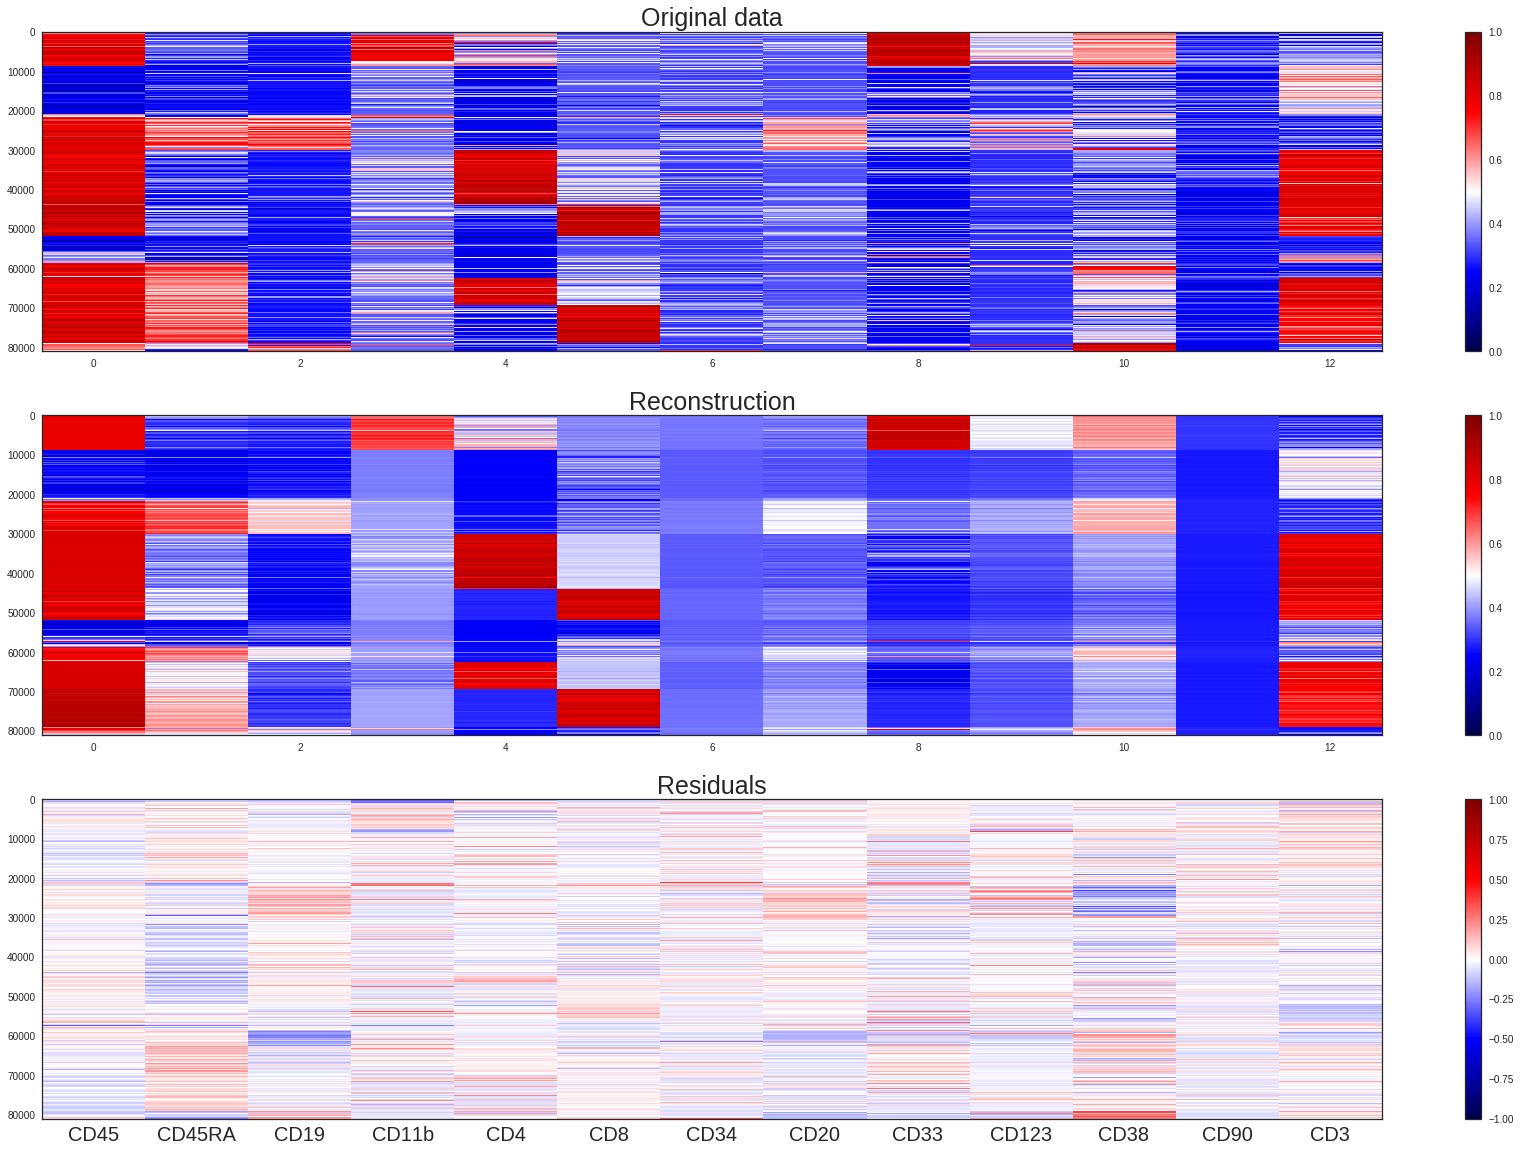

In [30]:
data_dec_2 = autoencoder_2.predict(data_norm)
plot_reconstruction(data_norm, data_dec_2)
# better than previous model

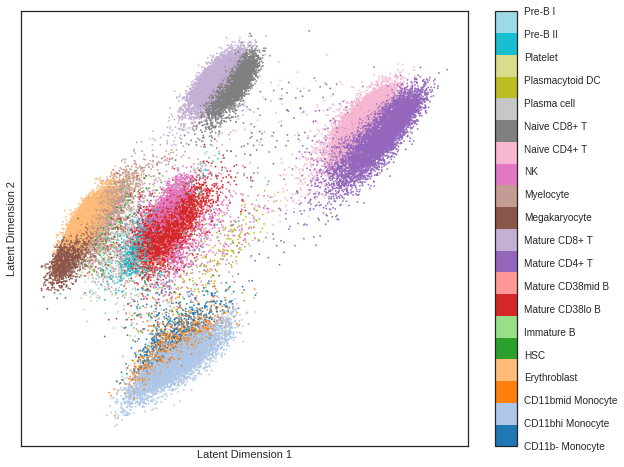

In [32]:
x_enc_2 = encoder_2.predict(x_train, batch_size=256)
plot_encoded(x_enc_2, y_train)

# now the CD8+ and CD4+ cells are split
# => we can better see the structure

# cell populations: very different size; there is also order within the cluster
# (e.g. along y-axis, separation by number of cells)

Let's add one more layer to the network:

In [33]:
# more layer: 13->7->4->2->4->7->13

reproduce(10)
input_dim = 13
intermediate_1 = 7
intermediate_2 = 4
latent_dim = 2

input_data = Input(shape=(input_dim,))
encoded_1 = Dense(intermediate_1, activation='relu')(input_data)
encoded_2 = Dense(intermediate_2, activation='relu')(encoded_1)
encoded_3 = Dense(latent_dim, activation='relu')(encoded_2)
decoded_1 = Dense(intermediate_2, activation='relu')(encoded_3)
decoded_2 = Dense(intermediate_1, activation='relu')(decoded_1)
decoded_3 = Dense(input_dim, activation='sigmoid')(decoded_2)

autoencoder_3 = Model(input_data, decoded_3)

encoder_3 = Model(input_data, encoded_3)

autoencoder_3.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_3.summary()
autoencoder_3.fit(x_train, x_train,
                epochs=150,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 98        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 32        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 35        
_________________________________________________________________
dense_12 (Dense)             (None, 13)                104       
Total para

56752/56752 [==============================] - 0s 8us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 67/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 68/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 69/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0059 - val_loss: 0.0059
Epoch 70/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0058 - val_loss: 0.0058
Epoch 71/150
56752/56752 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0058
Epoch 72/150
56752/56752 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0058
Epoch 73/150
56752/56752 [==============================] - 0s 8us/step - loss: 0.0058 - val_loss: 0.0058
Epoch 74/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0058 - val_loss: 0.0058
Epoch 75/150
56752/56752 [==============================] -

56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 144/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 145/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 146/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 147/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 148/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 149/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053
Epoch 150/150
56752/56752 [==============================] - 0s 7us/step - loss: 0.0052 - val_loss: 0.0053


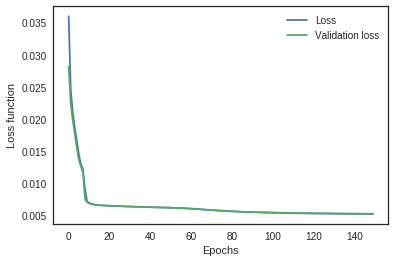

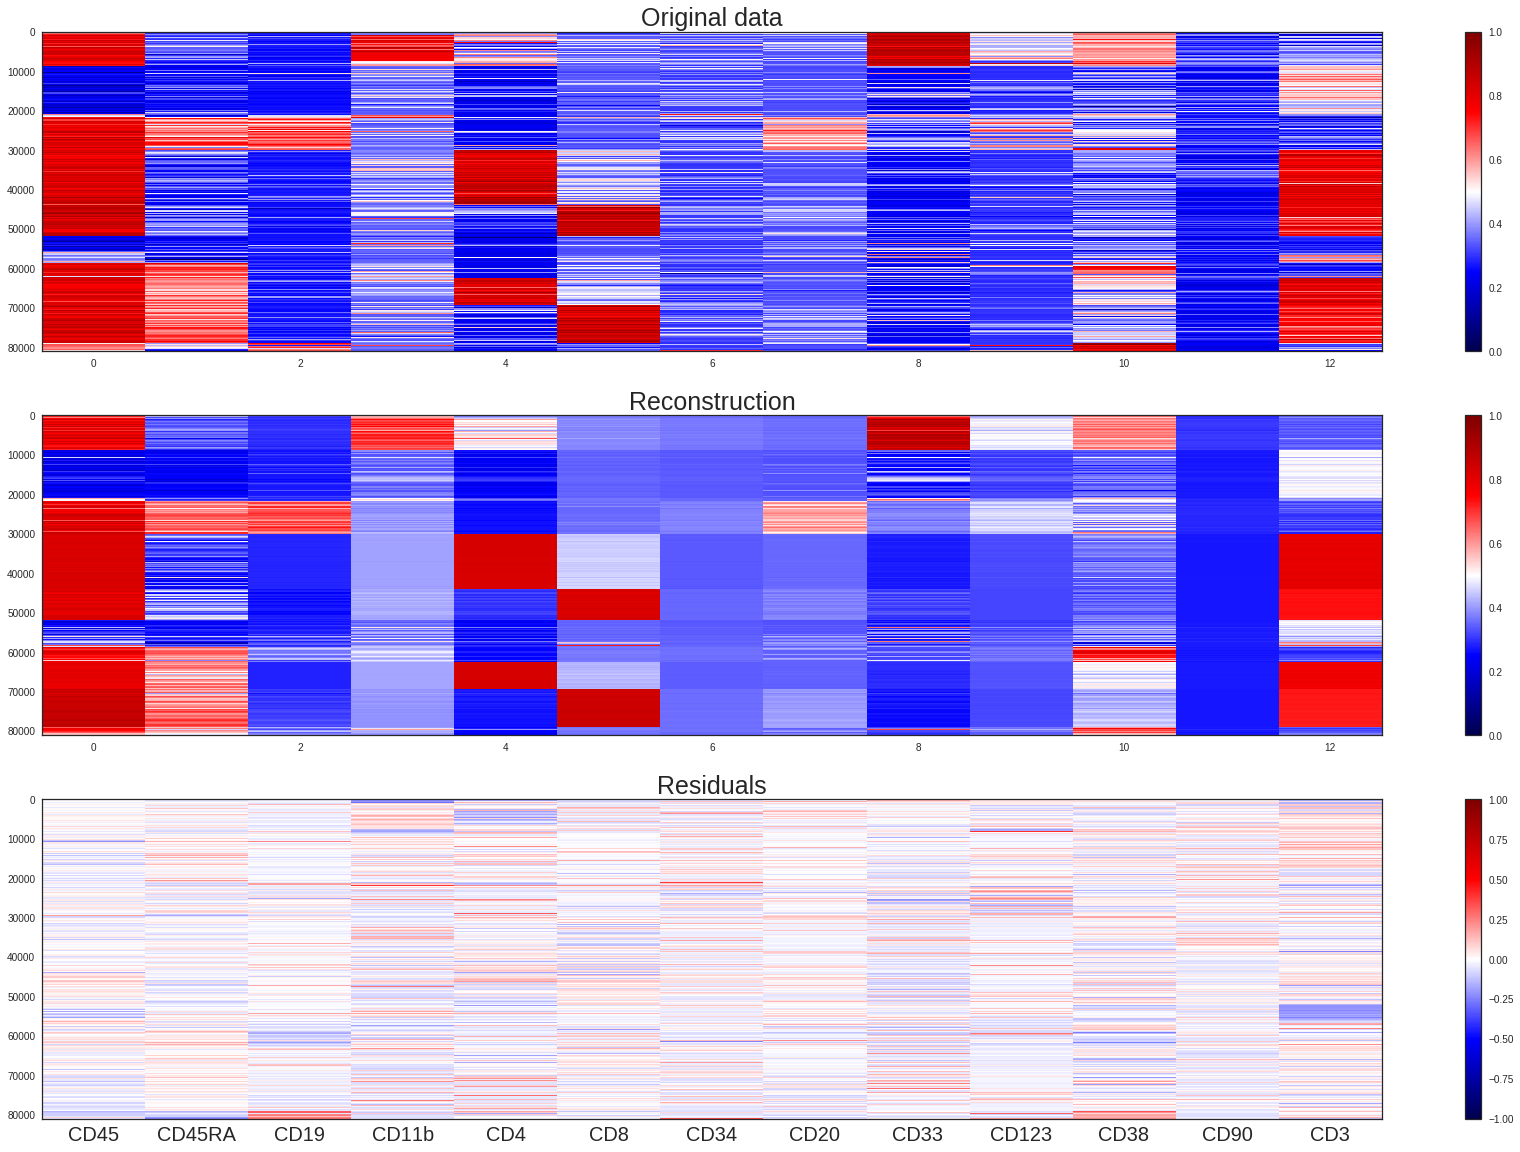

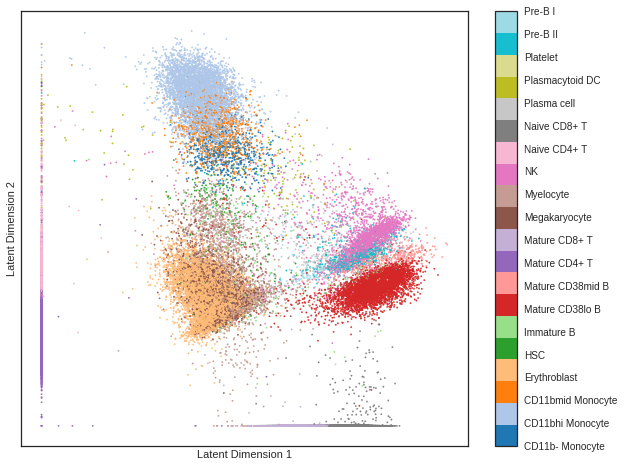

In [34]:
plot_history(autoencoder_3)
data_dec_3 = autoencoder_3.predict(data_norm)
plot_reconstruction(data_norm, data_dec_3)
x_enc_3 = encoder_3.predict(x_train, batch_size=256)
plot_encoded(x_enc_3, y_train)
# => better !
# small populations -> has seen less examples, will perform worse 
# (not many training examples to identify parameters of this population, so will not perform as well)

# some population: lines along the axes
# before separable "cloud", became the lines, 
# in the previous classfiier, were separable by a line, easier to separate them by a point
# network collapse them into lines
# same clusters than with the previous classifier
# previous neurons enough for separate them
# from classification point of a view, it is a good job

# Summary
Let's summarize the results of the 3 autoencoders:

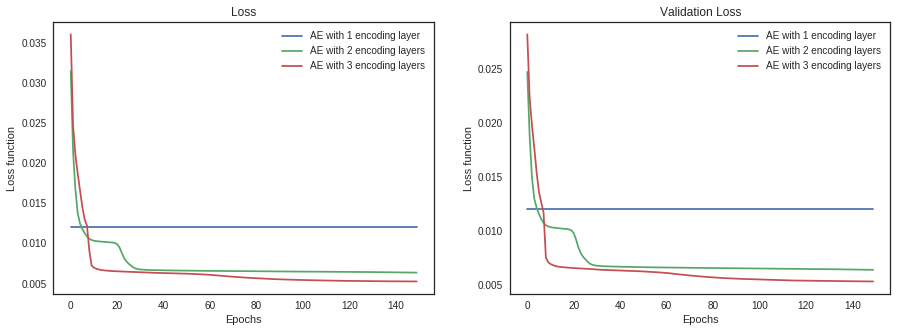

In [35]:
#compare plot history
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(autoencoder_1.history.history['loss'])
plt.plot(autoencoder_2.history.history['loss'])
plt.plot(autoencoder_3.history.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend(['AE with 1 encoding layer','AE with 2 encoding layers', 'AE with 3 encoding layers'])

plt.subplot(1, 2, 2)
plt.plot(autoencoder_1.history.history['val_loss'])
plt.plot(autoencoder_2.history.history['val_loss'])
plt.plot(autoencoder_3.history.history['val_loss'])
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss function')
plt.legend(['AE with 1 encoding layer','AE with 2 encoding layers', 'AE with 3 encoding layers'])
plt.show()

# from the 1st -> 2nd very better
# from 2nd -> 3d, start to be at the limit from what you can get, better but not very much better

# if add layer => will become worse
# when you visualize the weights, you will see identical weights, 
# e.g. because you don't need both, you will need only 1, you will have correlated weights 
# also you will increase the complexity, but this will not improve the loss 

# you can include cluster-specific distance to the cost function (but not typical application of encoder)
# but need to make hard assumptions (number of clusters not known in advance)
# if you have believes about data, you can use it for defining loss function

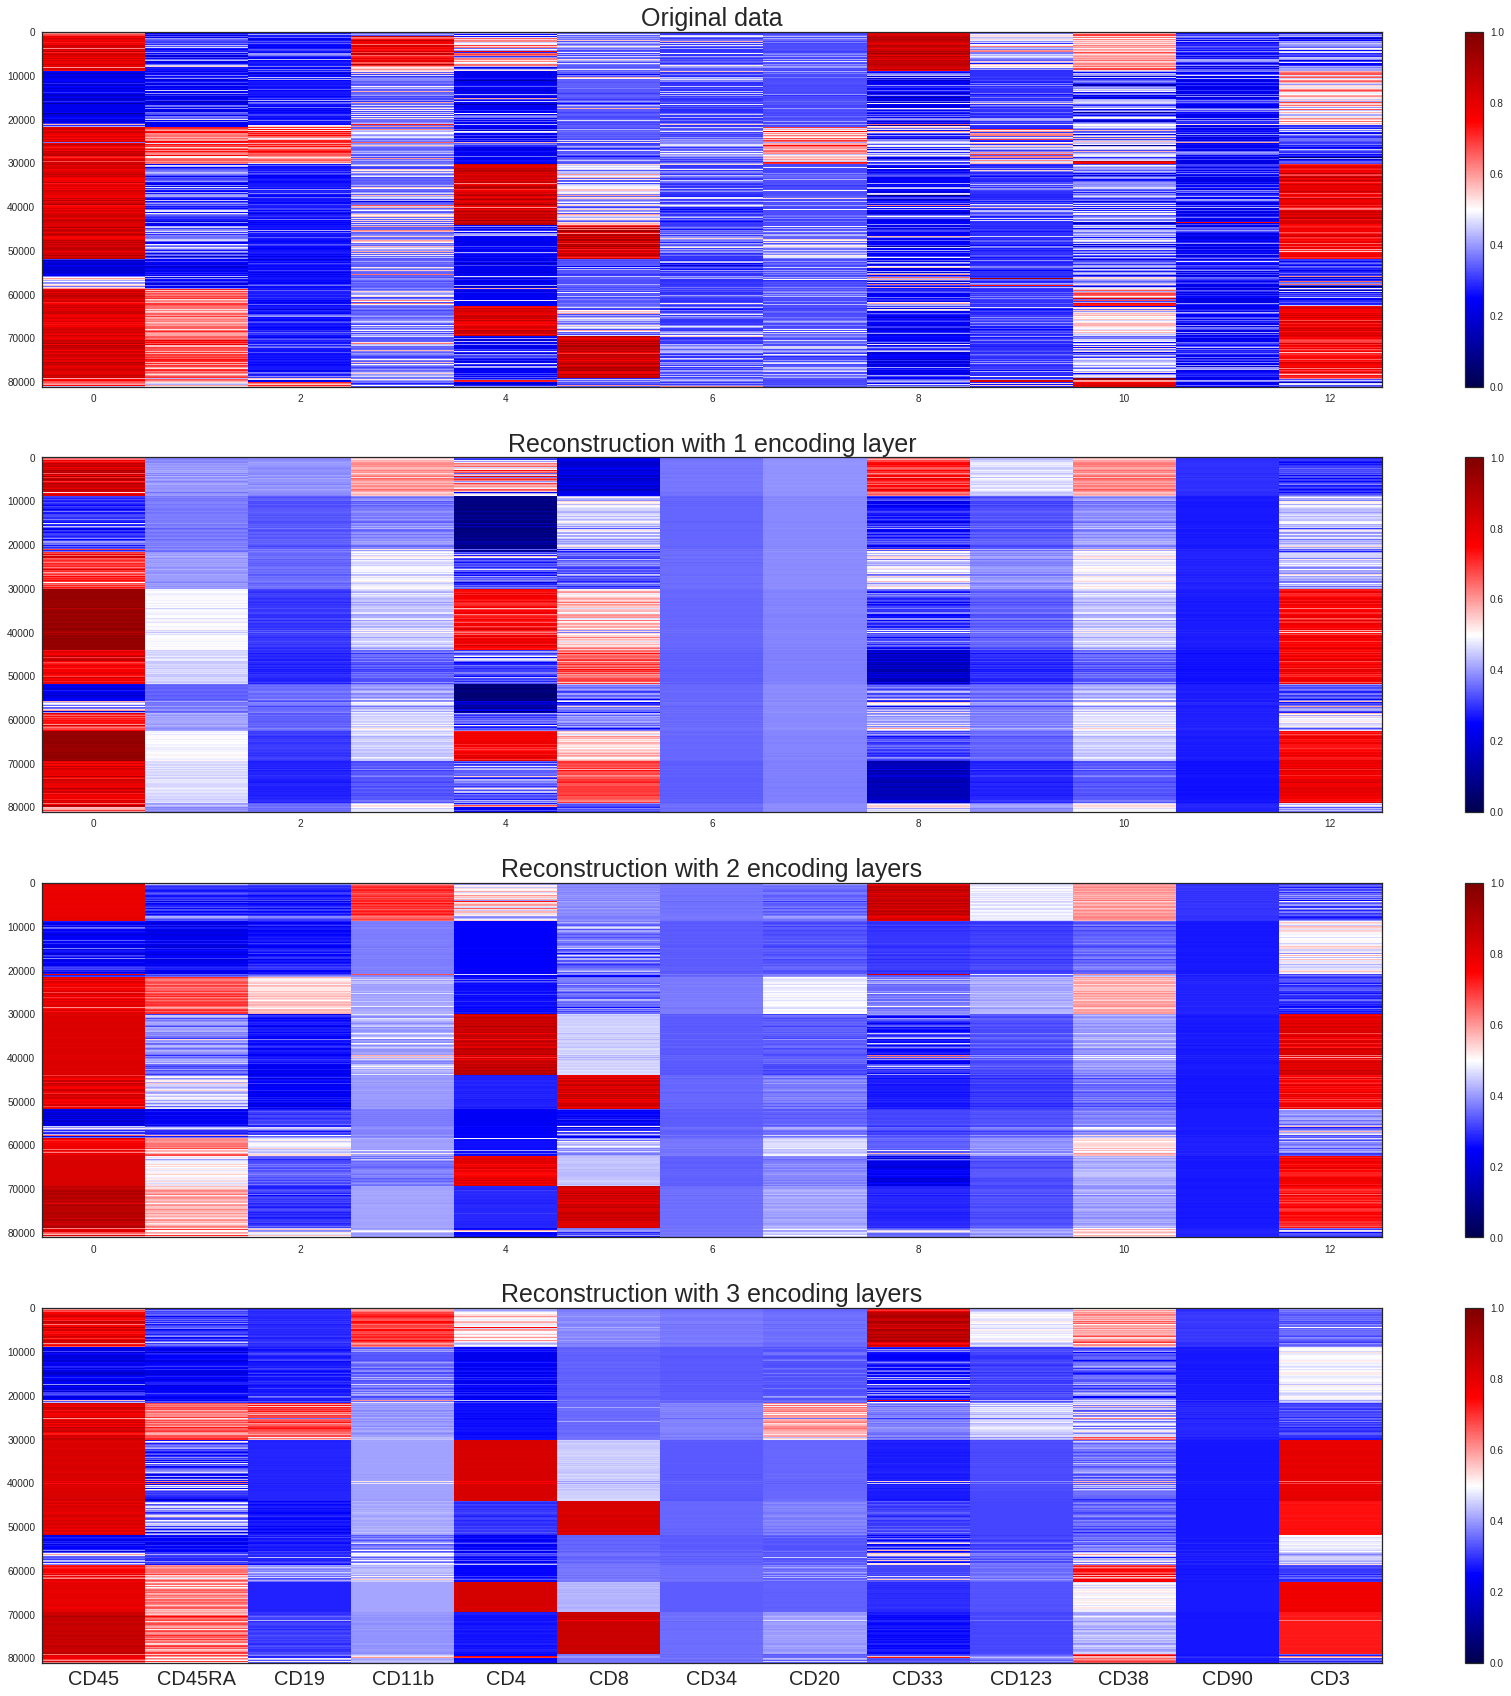

In [36]:
#compare reconstructions
plt.figure(figsize=(30,30))
plt.subplot(4, 1, 1)
ax1 = plt.imshow(data_norm, cmap="seismic", aspect="auto", vmin=0, vmax=1)
plt.title('Original data', fontsize=25)
cbar = plt.colorbar(ax1)

plt.subplot(4, 1, 2)
ax2 = plt.imshow(data_dec_1, cmap="seismic", aspect="auto", vmin=0, vmax=1)
cbar = plt.colorbar(ax2)
plt.title('Reconstruction with 1 encoding layer', fontsize=25)

plt.subplot(4, 1, 3)
ax3 = plt.imshow(data_dec_2, cmap="seismic", aspect="auto", vmin=0, vmax=1)
cbar = plt.colorbar(ax3)
plt.title('Reconstruction with 2 encoding layers', fontsize=25)

plt.subplot(4, 1, 4)
ax4 = plt.imshow(data_dec_3, cmap="seismic", aspect="auto", vmin=0, vmax=1)
plt.title('Reconstruction with 3 encoding layers', fontsize=25)
plt.gca().set_xticks(range(13))
plt.gca().set_xticklabels(markers, fontsize=20)
cbar = plt.colorbar(ax4)

plt.show()

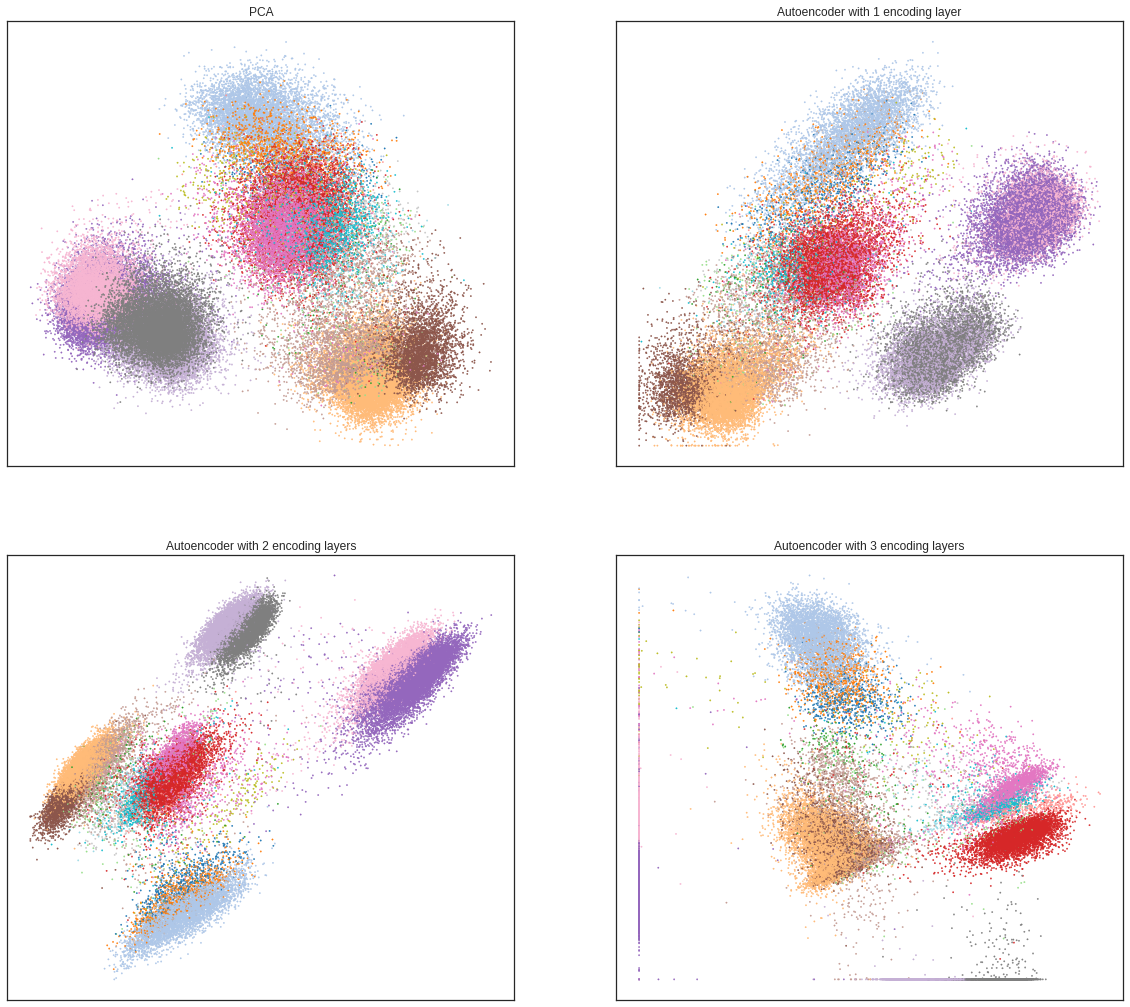

In [38]:
#Compare dimensionality reduction
fig = plt.figure(figsize=(20, 18))

plt.subplot(2,2,1)
ax = plt.scatter(Y[:, 0], Y[:, 1], s=2, c=labels, cmap="tab20")
ax.set_facecolor('white')
plt.title('PCA')
plt.xticks([])
plt.yticks([])


plt.subplot(2,2,2)
ax = plt.scatter(x_enc_1[:, 0], x_enc_1[:, 1], s=2, c=y_train, cmap="tab20")
ax.set_facecolor('white')
plt.title('Autoencoder with 1 encoding layer')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,3)
ax = plt.scatter(x_enc_2[:, 0], x_enc_2[:, 1], s=2, c=y_train, cmap="tab20")
ax.set_facecolor('white')
plt.title('Autoencoder with 2 encoding layers')
plt.xticks([])
plt.yticks([])

plt.subplot(2,2,4)
ax = plt.scatter(x_enc_3[:, 0], x_enc_3[:, 1], s=2, c=y_train, cmap="tab20")
ax.set_facecolor('white')
plt.title('Autoencoder with 3 encoding layers')
plt.xticks([])
plt.yticks([])

plt.show()

=> to choose, look also at the stability

in the 3 encoding layers -> more clusters

(even if population in lines, you can cut between them at some points)

Now let's use the best autoencoder to gain more insight on the populations:

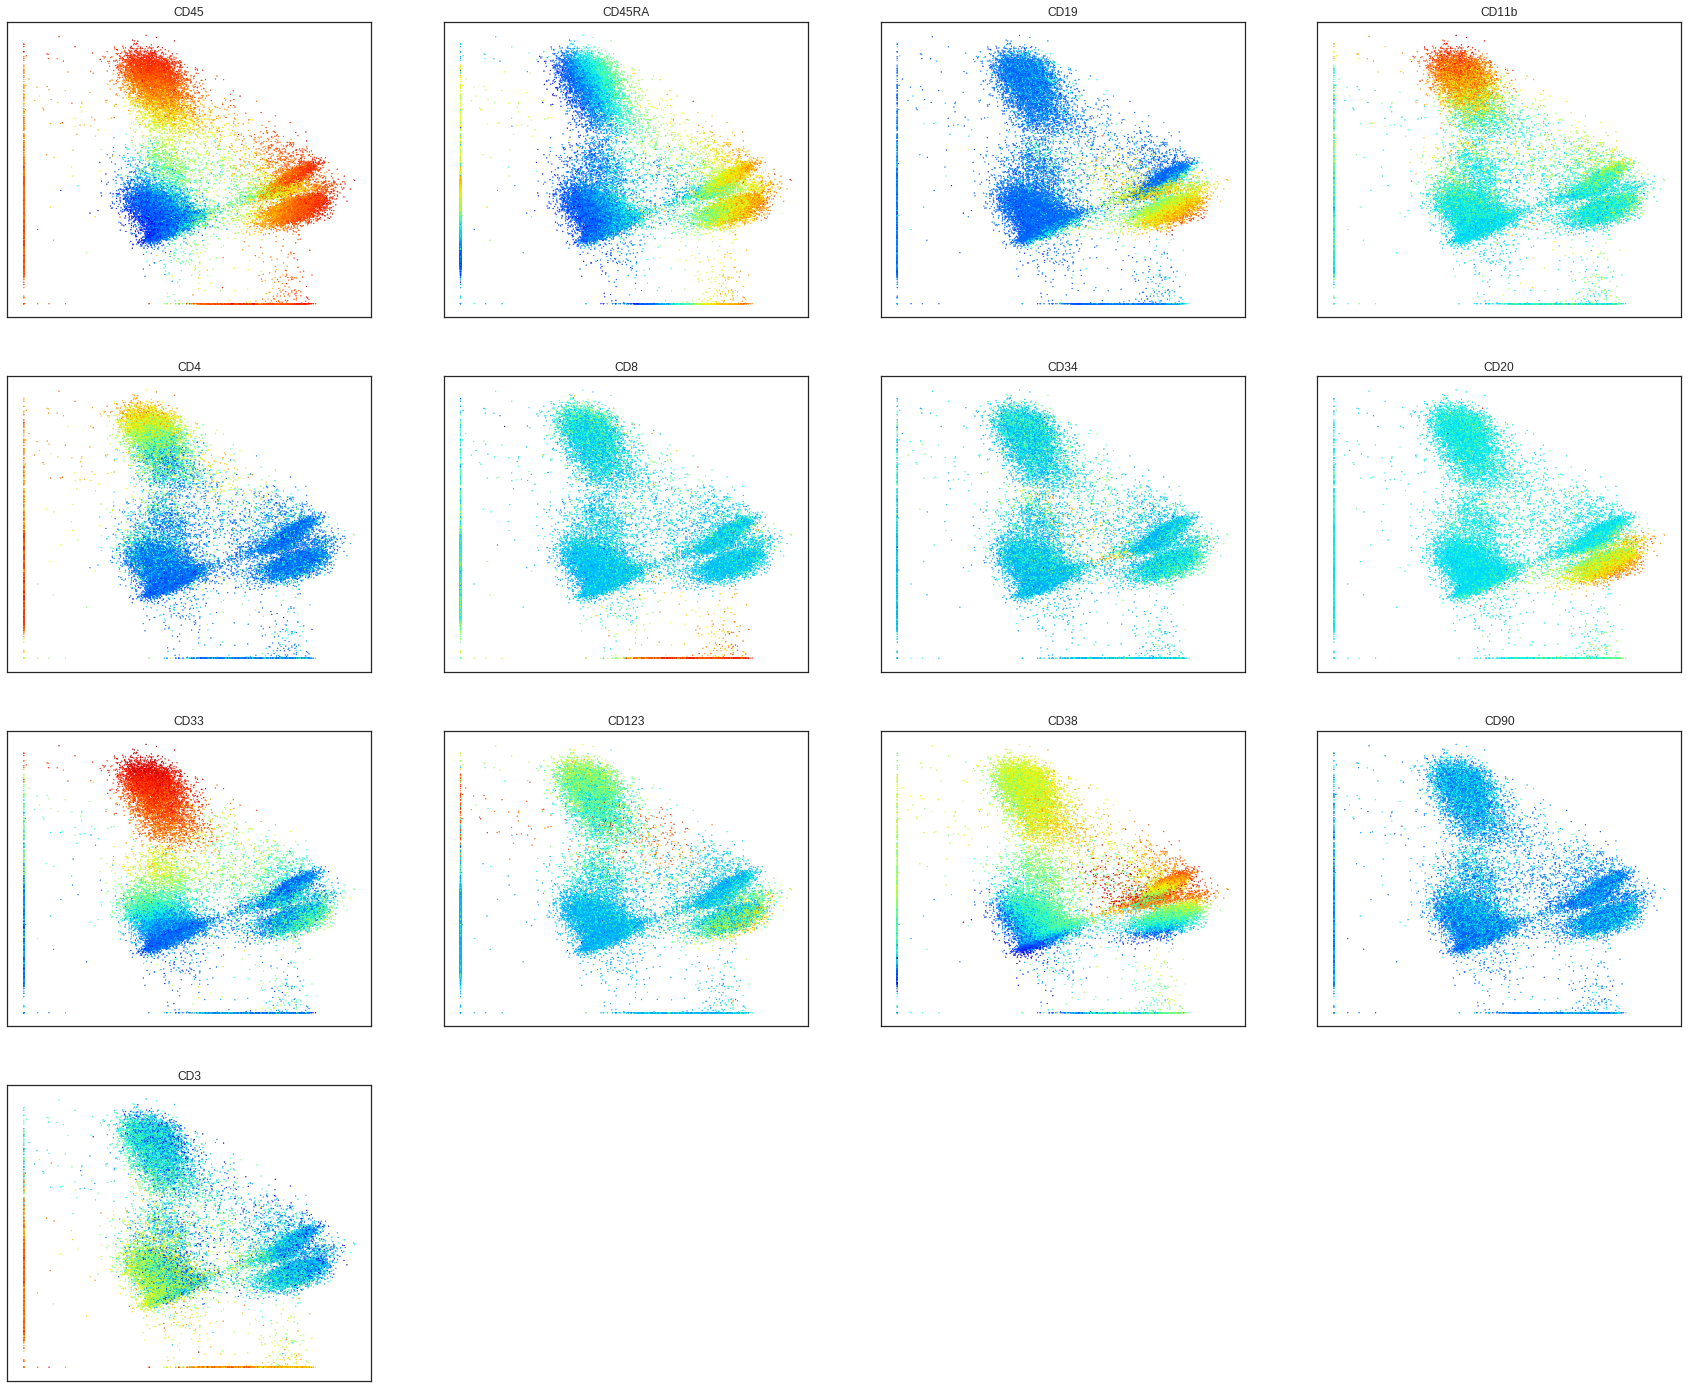

In [39]:
fig = plt.figure(figsize=(30, 25))
for m in range(13):
    plt.subplot(4, 4, m+1)
    plt.scatter(x_enc_3[:, 0], x_enc_3[:, 1], s=1, c=x_train[:,m], cmap="jet")
    plt.title(markers[m])
    plt.xticks([])
    plt.yticks([]) 
plt.show()

# plot expression of the markers labels are the intensities of each protein
# understand what the network is learning and what are the populations (in normal situations, 
# you don't have the labels, e.g. you want to discriminate cancer vs. normal)